# Lab 6

In this lab, you will:

* Implement and tune a PI controller on the TCLab system. Demonstrate the need and implement an anti-reset windup strategy.
* Implement and tune a PID controller. Demonstrate the need for a low-pass filter and implement it.

# Exercise 1

Design and implement a  PI controller (without anti-reset windup) on the Q1/T1 system. Try different controller settings (using any tuning strategies recommended by Chapter 8). Demonstrate the need for anti-reset windup by putting in a large disturbance (from Q2) or a large change in setpoint which saturates the controller for a long time.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tclab
import time


def pi1(sp, pv, ierr, dt, params):
    '''
    Parameters
    ----------
    sp: setpoints (T, in degC)
    pv: present values (T, in degC)
    ierr: integral error
    dt: unit of time (s)
    params: list PI parameters (Kc, tauI)
    
    Returns
    -------
    op: total PI output
    P: proportional contribution to PI output
    I: integral contribution to PI output
    ierr: updated integral error
    '''
    Kc = params[0]
    tauI = params[1]
    KI = Kc/tauI
    
    #Calculate the error:
    error = sp[1]-pv[1]
    last_error = sp[0]-pv[0]
    
    # calculate the integral error
    ierr = ierr + (error+last_error)/2*dt
    
    # Calculate P contribution
    P = Kc*error
    
    # Calculate I contribution
    I = KI*ierr
    
    # ubias for controller (initial heater)
    op_bias = 0
    
    # How to add in anti-reset windup?
    op = op_bias + P + I
    op = max(0,min(100,op))
    return [op, P, I, ierr, error]   

In [5]:
params = [8,100]
start_time = time.time()
prev_time = start_time

n = 600  # Number of second time points 
tm = np.linspace(0,n-1,n) # Time values
lab = tclab.TCLab()
T1_woAWR = np.zeros(n)
Q1_woAWR = np.zeros(n)

error_woAWR = np.zeros(n)
ierr_woAWR = np.zeros(n)

SP1_woAWR = np.ones(n)*23.0
SP1_woAWR[20:] = 60.0
SP1_woAWR[300:] = 40.0

T1_woAWR[0] = lab.T1
for i in range(1,n):
    # record measurement
    T1_woAWR[i] = lab.T1
    print(T1_woAWR[i])
    
    # Record time and change in time
    t = time.time()
    dt = t - prev_time
    
    #calculation:
    Qcal_woAWR= pi1([SP1_woAWR[i],SP1_woAWR[i-1]], [T1_woAWR[i],T1_woAWR[i-1]], ierr_woAWR[i], dt, params)
    Q1_woAWR[i] = Qcal_woAWR[0]
    ierr_woAWR[i] = Qcal_woAWR[3]
    error_woAWR[i] = Qcal_woAWR[4]
    lab.Q1(Q1_woAWR[i])
    
    time.sleep(1)
lab.close()
# Save data file
data = np.vstack((tm,Q1_woAWR,T1_woAWR,SP1_woAWR, ierr_woAWR)).T
np.savetxt('PI_noAWR.csv',data,delimiter=',',\
           header='Time,Q1_noAWR,T1,SP1,ierr',comments='')

TCLab version 0.4.9
Arduino Leonardo connected on port COM4 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
25.797
26.022
25.99
25.99
25.958
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.797
26.216
26.248
26.313
26.248
26.409
26.57
26.57
26.699
26.764
26.893
27.118
27.473
27.537
27.795
27.859
28.117
28.375
28.633
28.697
29.148
29.31
29.535
29.729
30.115
30.502
30.663
30.953
31.308
31.694
31.759
32.017
32.371
32.661
33.016
33.209
33.499
33.918
34.305
34.595
34.917
35.143
35.529
35.755
35.884
36.271
36.561
36.883
37.173
37.592
37.882
38.011
38.107
38.526
38.881
39.074
39.461
39.558
39.848
40.267
40.428
40.686
41.072
41.362
41.685
41.975
42.2
42.426
42.619
42.877
43.167
43.554
43.715
43.908
44.166
44.553
44.746
44.811
45.229
45.487
45.745
45.971
46.164
46.486
46.647
46.873
47.034
47.163
47.453
47.872
48.098
48.227
48.484
48.742
48.871
49.064
49.226
49.548
49.741
50.031
50.257
50.482
50.708
51.063
51.159
51.385
51.5

In [4]:
def pi2(sp, pv, ierr, dt, params):

    Kc = params[0]
    tauI = params[1]
    KI = Kc/tauI
    
    #Calculate the error:
    error = sp[1]-pv[1]
    last_error = sp[0]-pv[0]
    
    # calculate the integral error
    ierr = ierr + (error+last_error)/2*dt
    
    # Calculate P contribution
    P = Kc*error
    
    # Calculate I contribution
    I = KI*ierr
    
    # ubias for controller (initial heater)
    op_bias = 0
    
    # How to add in anti-reset windup?
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    op = op_bias + P + I
    if op < oplo or op > ophi:
        ierr = ierr-error*dt
    # clip output
        op = max(oplo,min(ophi,op))
    
    return [op, P, I, ierr, error]  

In [6]:
params = [8,100]
ierr_AWR = 0.0
start_time = time.time()
prev_time = start_time

n = 600  # Number of second time points 
tm = np.linspace(0,n-1,n) # Time values
lab = tclab.TCLab()
T1_AWR = np.zeros(n)
Q1_AWR = np.zeros(n)
error_AWR = np.zeros(n)
ierr_AWR = np.zeros(n)
# step setpoint from 23.0 to 40.0 degC
SP1_AWR = np.ones(n)*23.0
SP1_AWR[20:] = 60.0
SP1_AWR[300:] = 40.0

T1_AWR[0] = lab.T1
for i in range(1,n):
    # record measurement
    T1_AWR[i] = lab.T1
    print(T1_AWR[i])
    
    # Record time and change in time
    t = time.time()
    dt = t - prev_time
    
    #calculation:
    Qcal_AWR= pi2([SP1_AWR[i],SP1_AWR[i-1]], [T1_AWR[i],T1_AWR[i-1]], ierr_AWR[i], dt, params)
    Q1_AWR[i] = Qcal_AWR[0]
    ierr_AWR[i] = Qcal_AWR[3]
    error_AWR[i] = Qcal_AWR[4]
    lab.Q1(Q1_AWR[i])
    
    time.sleep(1)
lab.close()
# Save data file
data = np.vstack((tm,Q1_AWR,T1_AWR,SP1_AWR,ierr_AWR)).T
np.savetxt('PI_AWR.csv',data,delimiter=',',\
           header='Time,Q1_AWR,T1,SP1,ierr',comments='')

TCLab version 0.4.9
Arduino Leonardo connected on port COM4 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
26.055
26.119
26.087
26.119
26.119
26.055
26.055
25.926
25.765
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.797
26.184
26.184
26.28
26.345
26.28
26.345
26.57
26.506
26.828
26.957
27.054
27.215
27.537
27.537
27.859
28.149
28.407
28.439
28.665
28.955
29.406
29.729
29.793
30.083
30.341
30.631
30.889
31.114
31.469
31.823
32.113
32.339
32.758
33.048
33.338
33.596
33.95
34.208
34.53
34.885
35.271
35.594
35.852
36.077
36.367
36.496
36.915
37.27
37.463
37.785
38.236
38.462
38.72
39.171
39.235
39.429
39.751
40.041
40.299
40.686
41.008
41.169
41.523
41.91
42.039
42.232
42.555
42.813
43.07
43.328
43.554
44.037
44.198
44.456
44.617
44.875
45.133
45.584
45.584
45.874
46.164
46.422
46.486
46.647
47.099
47.228
47.518
47.808
48.098
48.13
48.484
48.549
48.678
49.064
49.226
49.516
49.806
49.935
50.096
50.289
50.45
50.644
50.901
51.224
51.417
51.675
5

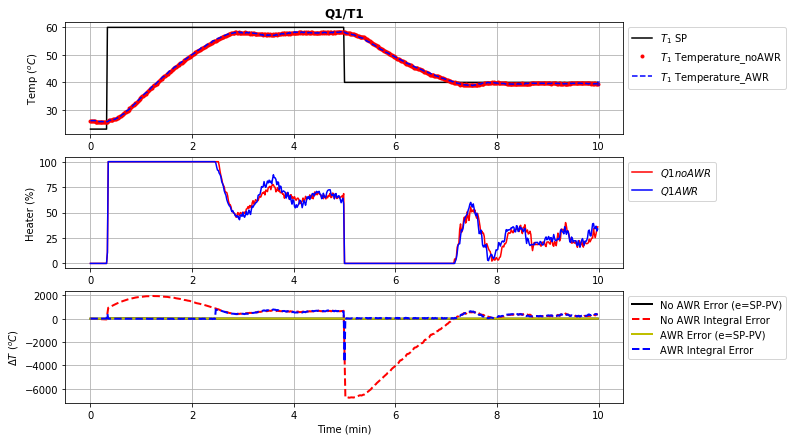

Kc, tauI:  [8, 100]


In [9]:
# Create Figure
plt.figure(figsize=(10,7))
ax = plt.subplot(3,1,1)
ax.grid()
plt.title('Q1/T1', weight='bold')

plt.plot(tm/60.0,SP1_AWR,'k-',label=r'$T_1$ SP')
plt.plot(tm/60.0,T1_woAWR,'r.',label=r'$T_1$ Temperature no AWR')
plt.plot(tm/60.0,T1_AWR,'b--',label=r'$T_1$ Temperature AWR')

plt.plot([tm[-1]/60.0,tm[-1]/60.0],[SP1_AWR[-1],T1_AWR[-1]],\
         'b-',lw=3,alpha=0.5)

plt.ylabel(r'Temp ($^oC$)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax = plt.subplot(3,1,2)
ax.grid()
plt.plot(tm/60.0,Q1_woAWR,'r-',label=r'$Q1 noAWR$')
plt.plot(tm/60.0,Q1_AWR,'b-',label=r'$Q1 AWR$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = plt.subplot(3,1,3)
ax.grid()
plt.plot(tm/60,error_woAWR,'k-',linewidth=2,label='No AWR Error (e=SP-PV)')
plt.plot(tm/60,ierr_woAWR,'r--',linewidth=2,label='No AWR Integral Error')
plt.plot(tm/60,error_AWR,'y-',linewidth=2,label='AWR Error (e=SP-PV)')
plt.plot(tm/60,ierr_AWR,'b--',linewidth=2,label='AWR Integral Error')
plt.ylabel(r'$\Delta T$ $(^oC)$')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


####  With the anti-reset windup, Q1 has less of an error involved and appears to react quicker in reaching a desired temperature, it also seems to have less osscillation near the end of the cycle. To help with respond time, and overshoot we should implemet the anti-reset windup (AWR) to better tune the PI controller.

# Exercise 2

Implement and tune a PI controller on the Q1/T2 system. Experiment with its performance and tuning of the controller.

#### We have shown in Excercise 1 there is a need for the AWR so we will just Tune a PI controller on the Q1/T2 system

In [37]:
params = [8,100]
ierr_AWR = 0.0
start_time = time.time()
prev_time = start_time

n = 600  # Number of second time points 
tm = np.linspace(0,n-1,n) # Time values
lab = tclab.TCLab()
T1_AWR = np.zeros(n)
T2_AWR = np.zeros(n)
Q1_AWR = np.zeros(n)
error2_AWR = np.zeros(n)
ierr2_AWR = np.zeros(n)
# step setpoint from 23.0
SP2_AWR = np.ones(n)*23.0
SP2_AWR[20:] = 60.0
SP2_AWR[300:] = 40.0

T1_AWR[0] = lab.T1
T2_AWR[0] = lab.T2
print('T2')

for i in range(1,n):
    # record measurement
    T1_AWR[i] = lab.T1
    T2_AWR[i] = lab.T2

    print(T1_AWR[i],T2_AWR[i])
    
    # Record time and change in time
    t = time.time()
    dt = t - prev_time
    
    #calculation:
    Qcal_AWR= pi_AWR([SP2_AWR[i],SP2_AWR[i-1]], [T2_AWR[i],T2_AWR[i-1]], ierr2_AWR[i], dt, params)
    Q1_AWR[i] = Qcal_AWR[0]
    ierr2_AWR[i] = Qcal_AWR[3]
    error2_AWR[i] = Qcal_AWR[4]
    lab.Q1(Q1_AWR[i])
    
    time.sleep(1)
lab.close()
data = np.vstack((tm,Q1_AWR,T2_AWR,T1_AWR,SP2_AWR,ierr2_AWR)).T
np.savetxt('PI_AWR.csv',data,delimiter=',',\
           header='Time,Q1_AWR,T2,T1,SP1,ierr',comments='')

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
T1,   T2
26.055 25.732
26.055 25.732
26.055 25.636
26.022 25.732
26.055 25.732
26.055 25.7
26.022 25.636
26.022 25.732
26.055 25.732
26.055 25.732
26.055 25.732
26.055 25.732
26.022 25.732
25.99 25.732
26.022 25.732
26.055 25.732
26.055 25.732
26.022 25.732
26.022 25.668
26.022 25.732
26.055 25.765
26.248 26.022
26.345 25.894
26.409 25.926
26.603 25.99
26.506 25.958
26.603 26.055
26.796 25.958
26.731 25.861
26.893 25.99
27.086 25.861
27.312 25.926
27.408 25.958
27.634 26.087
27.956 25.99
28.085 26.119
28.407 26.055
28.439 26.022
28.826 26.119
29.084 26.184
29.535 26.248
29.696 26.151
30.083 26.216
30.47 26.151
30.76 26.248
30.792 26.151
31.275 26.248
31.727 26.345
31.855 26.216
32.113 26.409
32.436 26.377
32.758 26.474
33.112 26.538
33.402 26.635
33.628 26.57
33.982 26.441
34.337 26.506
34.627 26.506
34.917 26.57
35.143 26.57
35.497 26.796
35.884 26.731
36.109 26.86


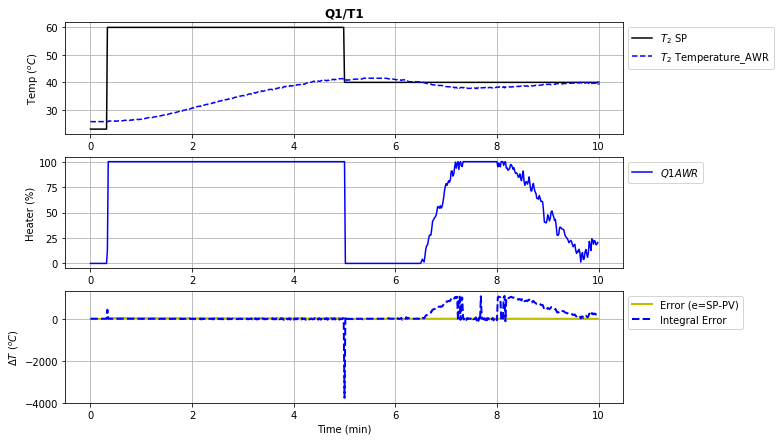

Kc, tauI:  [8, 100]


In [38]:
plt.figure(figsize=(10,7))
ax = plt.subplot(3,1,1)
ax.grid()
plt.title('Q1/T1', weight='bold')

plt.plot(tm/60.0,SP2_AWR,'k-',label=r'$T_2$ SP')
plt.plot(tm/60.0,T2_AWR,'b--',label=r'$T_2$ Temperature_AWR')

plt.plot([tm[-1]/60.0,tm[-1]/60.0],[SP2_AWR[-1],T2_AWR[-1]],\
         'b-',lw=3,alpha=0.5)

plt.ylabel(r'Temp ($^oC$)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax = plt.subplot(3,1,2)
ax.grid()
plt.plot(tm/60.0,Q1_AWR,'b-',label=r'$Q1  AWR$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = plt.subplot(3,1,3)
ax.grid()
plt.plot(tm/60,error2_AWR,'y-',linewidth=2,label='Error (e=SP-PV)')
plt.plot(tm/60,ierr2_AWR,'b--',linewidth=2,label='Integral Error')
plt.ylabel(r'$\Delta T$ $(^oC)$')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()
print('Kc, tauI: ',params)

# Exercise 3

Implement and tune a PID controller on the Q2/T2 system. Use numerical approximation of the derivative with first-order accuracy:

$$\frac{dy}{dt} \approx \frac{y_i - y_{i-1}}{\Delta t} $$

Note the effect of noise on the derivative action system. How can you dampen the effects due to noise? Implement some form of low pass filter to reduce the noise in the PID signal.

**Hint**: You can try using a numerical approximation of the derivative that takes into account earlier error measurements as one method. Similarly, you could take a weighted average of the current derivative of the error with previous values of the derivative of the error.

In [14]:
def pid(sp, pv, ierr, dt, params):
    
    Kc = params[0]
    tauI = params[1]
    tauD = params[2]
    KI = Kc/tauI
    KD = Kc*tauD
    
    #Calculate the error:
    error = sp[1]-pv[1]
    last_error = sp[0]-pv[0]
    
    # calculate the integral error
    ierr = ierr + (error+last_error)/2*dt
    
    # calculate the measurement derivative
    dpv = (pv[1] - pv[0]) / dt
    
    # Calculate P contribution
    P = Kc*error  
    # Calculate I contribution
    I = KI*ierr
    # Calculate D contribution
    D = -KD * dpv
    
    # ubias for controller (initial heater)
    op_bias = 0
    
    # How to add in anti-reset windup?
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    op = op_bias + P + I + D
    if op < oplo or op > ophi:
        ierr = ierr-error*dt
    # clip output
        op = max(oplo,min(ophi,op))
    
    return [op, P, I, D, ierr, error, dpv]  

In [15]:
params = [10,150,10]
ierr_AWR = 0.0
start_time = time.time()
prev_time = start_time

n = 300  # Number of second time points (5 min)
tm = np.linspace(0,n-1,n) # Time values
lab = tclab.TCLab()
T2_AWR = np.zeros(n)
Q2_AWR = np.zeros(n)
error2_AWR = np.zeros(n)
ierr2_AWR = np.zeros(n)
dev2_AWR=np.zeros(n)
# step setpoint:
SP2_AWR = np.ones(n)*23.0
SP2_AWR[20:] = 60.0
SP2_AWR[300:] = 40.0

T2_AWR[0] = lab.T2
for i in range(1,n):
    T2_AWR[i] = lab.T2
    print(T2_AWR[i])
    
    t = time.time()
    dt = t - prev_time
    
    #calculation:
    Qcal_AWR= pid([SP2_AWR[i],SP2_AWR[i-1]], [T2_AWR[i],T2_AWR[i-1]], ierr2_AWR[i], dt, params)
    Q2_AWR[i] = Qcal_AWR[0]
    ierr2_AWR[i] = Qcal_AWR[3]
    error2_AWR[i] = Qcal_AWR[4]
    dev2_AWR[i] = Qcal_AWR[4]
    
    lab.Q2(Q2_AWR[i])
    
    time.sleep(1)
lab.close()
data = np.vstack((tm,Q2_AWR,T2_AWR,SP2_AWR,ierr2_AWR, dev2_AWR)).T
np.savetxt('PID3_AWR.csv',data,delimiter=',',\
           header='Time,Q2_AWR,T2,SP2,ierr',comments='')

TCLab version 0.4.9
Arduino Leonardo connected on port COM4 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
35.4
35.239
35.078
35.078
35.078
35.078
35.078
35.078
34.981
34.853
34.853
34.788
34.756
34.756
34.756
34.756
34.756
34.659
34.53
34.434
34.434
35.207
35.207
35.207
35.207
35.078
34.82
34.691
34.691
34.563
34.563
34.563
34.691
34.981
35.11
34.788
35.014
35.014
35.626
35.4
35.594
35.69
35.852
35.852
35.98
36.142
36.045
35.948
35.755
36.367
36.399
36.528
36.818
36.818
37.076
37.012
37.108
37.012
37.012
36.947
36.818
37.076
37.785
37.817
38.075
38.075
37.979
37.85
37.946
37.85
37.785
37.785
38.107
38.236
38.913
38.784
39.042
39.396
39.3
39.235
39.332
39.848
40.041
40.009
40.073
39.88
39.751
40.396
40.686
40.46
40.782
40.782
40.653
40.75
40.524
40.46
41.201
41.104
41.04
41.233
41.427
41.588
41.781
41.846
41.749
41.749
41.556
41.652
41.781
41.942
42.49
42.555
42.49
42.394
42.361
42.555
42.329
42.426
42.619
42.974
43.328
43.457
43.683
43.618
43.521
43.489
43.586
43.457
43.

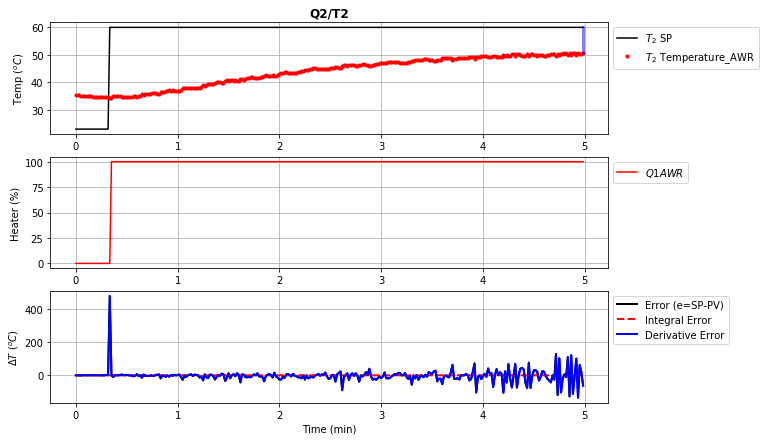

Kc, tauI, tauD:  [10, 150, 10]


In [16]:
plt.figure(figsize=(10,7))
ax = plt.subplot(3,1,1)
ax.grid()
plt.title('Q2/T2', weight='bold')

plt.plot(tm/60.0,SP2_AWR,'k-',label=r'$T_2$ SP')
plt.plot(tm/60.0,T2_AWR,'r.',label=r'$T_2$ Temperature_AWR')

plt.plot([tm[-1]/60.0,tm[-1]/60.0],[SP2_AWR[-1],T2_AWR[-1]],\
         'b-',lw=3,alpha=0.5)

plt.ylabel(r'Temp ($^oC$)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax = plt.subplot(3,1,2)
ax.grid()
plt.plot(tm/60.0,Q2_AWR,'r-',label=r'$Q1 AWR$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = plt.subplot(3,1,3)
ax.grid()
plt.plot(tm/60,error2_AWR,'k-',linewidth=2,label='Error (e=SP-PV)')
plt.plot(tm/60,ierr2_AWR,'r--',linewidth=2,label='Integral Error')
plt.plot(tm/60,dev2_AWR,'b-',linewidth=2,label='Derivative Error')
plt.ylabel(r'$\Delta T$ $(^oC)$')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


In [17]:
from scipy import signal
sos = signal.butter(1,15, 'lp', fs=300, output='sos')
filtered = signal.sosfilt(sos, dev2_AWR) + dev2_AWR[1]

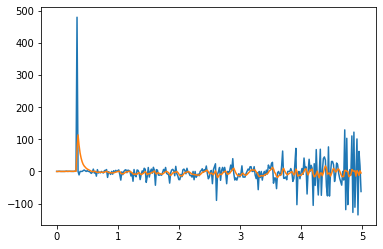

In [18]:
plt.plot(tm/60.0, dev2_AWR,label='unfiltered')
plt.plot(tm/60.0, filtered,label='filtered')

In [19]:
def pid_noisereduction(sp, pv, dpv, ierr, dt, params): #sp and pv are in [a.b] forms
    
    Kc = params[0]
    tauI = params[1]
    tauD = params[2]
    KI = Kc/tauI
    KD = Kc*tauD
    
    #Calculate the error:
    error = sp[1]-pv[1]
    last_error = sp[0]-pv[0]
    
    # calculate the integral error
    ierr = ierr + (error+last_error)/2*dt
    
    # calculate the measurement derivative
    #dpv = (pv[1] - pv[0]) / dt
    
    # Calculate P contribution
    P = Kc*error  
    # Calculate I contribution
    I = KI*ierr
    # Calculate D contribution
    D = -KD * dpv
    
    # ubias for controller (initial heater)
    op_bias = 0
    
    # How to add in anti-reset windup?
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    op = op_bias + P + I + D
    if op < oplo or op > ophi:
        ierr = ierr-error*dt
    # clip output
        op = max(oplo,min(ophi,op))
    
    return [op, P, I, D, ierr, error, dpv]  

In [20]:
Q2_noisereduction = np.zeros(n)
ierr2_noisereduction = np.zeros(n)
error2_noisereduction = np.zeros(n)

for i in range(1,n):
    Qcal_noisereduction= pid_noisereduction([SP2_AWR[i],SP2_AWR[i-1]], [T2_AWR[i],T2_AWR[i-1]], filtered[i], ierr2_AWR[i], dt, params)
    Q2_noisereduction[i] = Qcal_AWR[0]
    ierr2_noisereduction[i] = Qcal_AWR[3]
    error2_noisereduction[i] = Qcal_AWR[4]

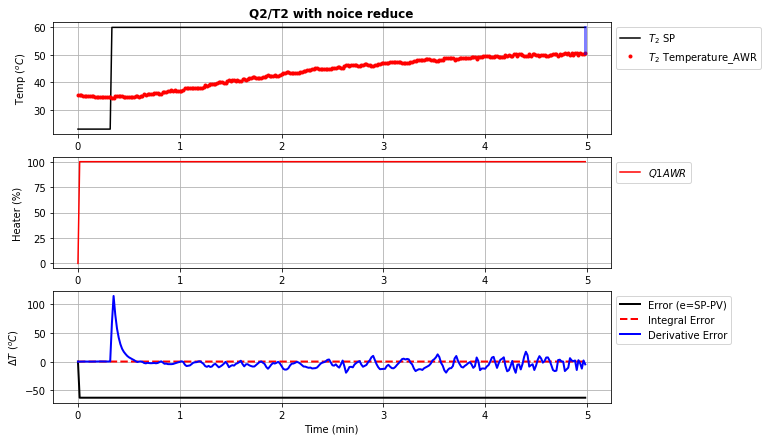

Kc, tauI, tauD:  [10, 150, 10]


In [21]:
# Create Figure
plt.figure(figsize=(10,7))
ax = plt.subplot(3,1,1)
ax.grid()
plt.title('Q2/T2 with noice reduce', weight='bold')

plt.plot(tm/60.0,SP2_AWR,'k-',label=r'$T_2$ SP')
plt.plot(tm/60.0,T2_AWR,'r.',label=r'$T_2$ Temperature_AWR')
plt.ylabel(r'Temp ($^oC$)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = plt.subplot(3,1,2)
ax.grid()
plt.plot(tm/60.0,Q2_noisereduction,'r-',label=r'$Q1 AWR$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = plt.subplot(3,1,3)
ax.grid()
plt.plot(tm/60,error2_noisereduction,'k-',linewidth=2,label='Error (e=SP-PV)')
plt.plot(tm/60,ierr2_noisereduction,'r--',linewidth=2,label='Integral Error')
plt.plot(tm/60,filtered,'b-',linewidth=2,label='Derivative Error')
plt.ylabel(r'$\Delta T$ $(^oC)$')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# Exercise 4

Implement and tune a PID controller on the Q2/T1 system. Experiment with its performance and tuning of the controller.

In [33]:
params = [10,150,10]
ierr_AWR = 0.0
start_time = time.time()
prev_time = start_time

n = 300  # Number of second time points (5 min)
tm = np.linspace(0,n-1,n) # Time values
lab = tclab.TCLab()
T1_AWR = np.zeros(n)
Q2_AWR = np.zeros(n)
error2_AWR = np.zeros(n)
ierr2_AWR = np.zeros(n)
dev2_AWR=np.zeros(n)
SP2_AWR = np.ones(n)*23.0
SP2_AWR[20:] = 60.0
SP2_AWR[300:] = 40.0

T1_AWR[0] = lab.T1
for i in range(1,n):
    # record measurement
    T1_AWR[i] = lab.T1
    print(T1_AWR[i])
    
    # Record time and change in time
    t = time.time()
    dt = t - prev_time
    
    #calculation:
    Qcal_AWR= pid([SP2_AWR[i],SP2_AWR[i-1]], [T1_AWR[i],T1_AWR[i-1]], ierr2_AWR[i], dt, params)
    Q2_AWR[i] = Qcal_AWR[0]
    ierr2_AWR[i] = Qcal_AWR[3]
    error2_AWR[i] = Qcal_AWR[4]
    dev2_AWR[i] = Qcal_AWR[4]
    
    lab.Q2(Q2_AWR[i])
    
    time.sleep(1)
lab.close()
data = np.vstack((tm,Q2_AWR,T1_AWR,SP2_AWR,ierr2_AWR, dev2_AWR)).T
np.savetxt('PID3_AWR.csv',data,delimiter=',',\
           header='Time,Q2_AWR,T2,SP2,ierr',comments='')

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.732
25.926
25.926
25.926
25.926
25.958
26.022
25.926
26.022
25.894
26.055
25.765
26.022
25.765
25.894
26.055
25.861
25.797
26.119
25.797
26.055
25.797
26.119
26.055
25.861
26.151
25.797
26.151
26.087
25.99
26.151
26.022
26.184
26.151
26.248
26.151
26.28
26.184
26.377
26.184
26.441
26.184
26.441
26.441
26.28
26.506
26.345
26.474
26.474
26.667
26.538
26.667
26.57
26.699
26.57
26.796
26.667
26.796
26.86
26.764
26.957
26.764
27.086
26.893
27.086
26.764
27.183
27.021
27.054
27.247
27.247
27.279
27.344
27.183
27.312
27.473
27.376
27.537
27.408
27.666
27.505
27.666
27.666
27.537
27.763
27.505
27.827
27.698
27.988
27.988
27.795
28.053
27.763
28.149
28.149
28.117
28.311
28.053
28.214
28.182
28.375
28.472
28.343
28.504
28.375
28.439
28.

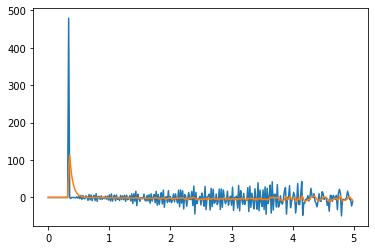

In [34]:
#Dampen the effect of the noise:
from scipy import signal
sos = signal.butter(1,15, 'lp', fs=300, output='sos')
filtered = signal.sosfilt(sos, dev2_AWR) + dev2_AWR[1]
plt.plot(tm/60.0, dev2_AWR)
plt.plot(tm/60.0, filtered)

In [35]:
Q2_noisereduction = np.zeros(n)
ierr2_noisereduction = np.zeros(n)
error2_noisereduction = np.zeros(n)
for i in range(1,n):
    Qcal_noisereduction = pid_noisereduction([SP2_AWR[i],SP2_AWR[i-1]], [T1_AWR[i],T1_AWR[i-1]], filtered[i], ierr2_AWR[i], dt, params)
    Q2_noisereduction[i] = Qcal_AWR[0]
    ierr2_noisereduction[i] = Qcal_AWR[3]
    error2_noisereduction[i] = Qcal_AWR[4]

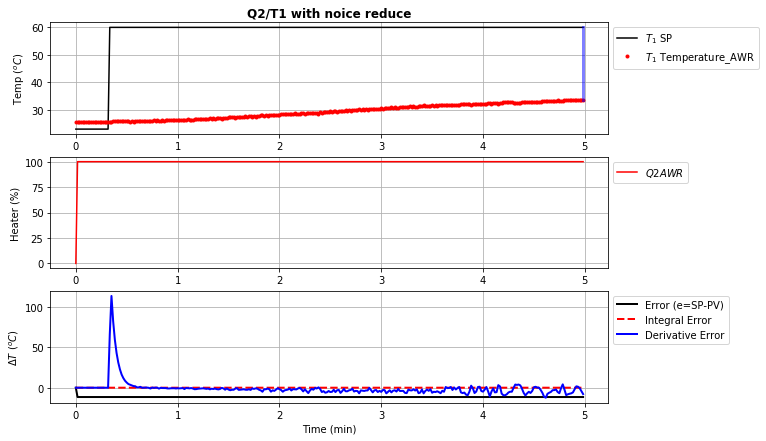

Kc, tauI, tauD:  [10, 150, 10]


In [36]:
# Create Figure
plt.figure(figsize=(10,7))
ax = plt.subplot(3,1,1)
ax.grid()
plt.title('Q2/T1 with noice reduce', weight='bold')
plt.plot(tm/60.0,SP2_AWR,'k-',label=r'$T_1$ SP')
plt.plot(tm/60.0,T1_AWR,'r.',label=r'$T_1$ Temperature_AWR')
plt.ylabel(r'Temp ($^oC$)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = plt.subplot(3,1,2)
ax.grid()
plt.plot(tm/60.0,Q2_noisereduction,'r-',label=r'$Q2 AWR$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = plt.subplot(3,1,3)
ax.grid()
plt.plot(tm/60,error2_noisereduction,'k-',linewidth=2,label='Error (e=SP-PV)')
plt.plot(tm/60,ierr2_noisereduction,'r--',linewidth=2,label='Integral Error')
plt.plot(tm/60,filtered,'b-',linewidth=2,label='Derivative Error')
plt.ylabel(r'$\Delta T$ $(^oC)$')
plt.xlabel('Time (min)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
